### Arsitektur Model

    +-----------------------------+
    |    Membaca dan Membersihkan |
    |           Teks              |
    | (Reading & Cleaning Text)   |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |       Tokenisasi BPE        |
    | (Byte Pair Encoding - BPE)  |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |   Membuat Kamus Token dan   |
    |      Mengubah Teks          |
    |     Menjadi Indeks          |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |     Definisi Model          |
    |     (Transformer Decoder)   |
    |      (Embedding +           |
    |      Positional Encoding)   |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |  Membuat Dataset dan        |
    |     DataLoader              |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |       Training Loop         |
    |     (Dengan Pencatatan      |
    |          Loss)              |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |     Visualisasi Loss        |
    +-------------+---------------+
                  |
                  v
    +-----------------------------+
    |     Menyimpan dan Memuat    |
    |  Model & Data Tokenisasi    |
    +-----------------------------+

Penjelasan Singkat
Membaca dan Membersihkan Teks:

- Membaca teks dari file dan membersihkan teks dari karakter yang tidak diinginkan.

Tokenisasi BPE:

- Menggunakan Byte Pair Encoding untuk mengubah teks menjadi token sub-kata.
- Membuat kamus token (vocabulary) berdasarkan token sub-kata.

Membuat Kamus Token dan Mengubah Teks Menjadi Indeks:

- Mengubah teks asli menjadi indeks berdasarkan kamus token yang telah dibuat.

Definisi Model (Transformer Decoder):

- Model Transformer menggunakan lapisan embedding, positional encoding, dan beberapa lapisan decoder.
- Membangun model dengan TensorFlow dan menyimpannya untuk digunakan nanti.

Membuat Dataset dan DataLoader:

- Menggunakan TensorFlow Dataset untuk memproses data yang telah di-tokenisasi menjadi batch untuk pelatihan.

Training Loop:

- Melatih model dengan dataset menggunakan optimizer dan loss function yang sesuai.
- Mencatat loss selama pelatihan untuk evaluasi kinerja model.

Visualisasi Loss:

- Membuat plot untuk visualisasi loss selama pelatihan untuk memantau kinerja model.

Menyimpan dan Memuat Model & Data Tokenisasi:

- Menyimpan model yang dilatih dan data tokenisasi (vocabulary dan teks yang telah di-tokenisasi).
- Memuat model dan data yang disimpan untuk melanjutkan pelatihan atau penggunaan model tanpa memulai dari awal.

### Membaca dan Membersihkan Teks

In [2]:
import os

def read_text_files(folder_path):
    texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                content = file.read().strip()
                if content:  # Check if the file is not empty
                    cleaned_content = clean_text(content)
                    texts.append(cleaned_content)
    return texts

def clean_text(text):
    # Remove unwanted characters
    unwanted_chars = ['*', '#', '_', ')', '(', '!', '?', '.', ',', '-']
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text

folder_path = './Dataset/nlp_dataset'
texts = read_text_files(folder_path)


In [3]:
def count_txt_files(folder_path):
    return sum(1 for filename in os.listdir(folder_path) if filename.endswith(".txt"))

num_files = count_txt_files(folder_path)
print(f"Number of .txt files in folder: {num_files}")

Number of .txt files in folder: 1000


In [4]:
texts = read_text_files(folder_path)
print(f"Number of texts read: {len(texts)}")

Number of texts read: 341


#### Tokenisasi BPE

In [5]:
import re
from collections import Counter, defaultdict
import pickle

def get_vocab(texts):
    vocab = Counter()
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        for word in words:
            vocab[' '.join(list(word)) + ' </w>'] += 1
    return vocab

vocab = get_vocab(texts)

def get_stats(vocab):
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = ' '.join(pair)
    replacement = ''.join(pair)
    for word in v_in:
        w_out = word.replace(bigram, replacement)
        v_out[w_out] = v_in[word]
    return v_out

num_merges = 10000
for i in range(num_merges):
    pairs = get_stats(vocab)
    if not pairs:
        break
    best = max(pairs, key=pairs.get)
    vocab = merge_vocab(best, vocab)

# Membuat kamus token ke indeks
token_vocab = {word.replace(' ', ''): i for i, word in enumerate(vocab.keys(), start=2)}
token_vocab['<pad>'] = 0
token_vocab['<unk>'] = 1

# Membalik kamus dari indeks ke token
inv_token_vocab = {idx: word for word, idx in token_vocab.items()}

# Definisikan fungsi tokenisasi BPE
def tokenize_bpe(texts, token_vocab):
    tokenized_texts = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        tokenized = []
        for word in words:
            token = ''.join([c if c in token_vocab else '<unk>' for c in word])
            tokenized.append(token_vocab.get(token, token_vocab['<unk>']))
        tokenized_texts.append(tokenized)
    return tokenized_texts

# Simpan token vocab dan encoded texts
token_vocab_path = './saved_model/saved_notebook_06/token_vocab.pkl'
inv_token_vocab_path = './saved_model/saved_notebook_06/inv_token_vocab.pkl'
encoded_texts_bpe_path = './saved_model/saved_notebook_06/encoded_texts_bpe.pkl'

with open(token_vocab_path, 'wb') as f:
    pickle.dump(token_vocab, f)

with open(inv_token_vocab_path, 'wb') as f:
    pickle.dump(inv_token_vocab, f)

encoded_texts_bpe = tokenize_bpe(texts, token_vocab)
with open(encoded_texts_bpe_path, 'wb') as f:
    pickle.dump(encoded_texts_bpe, f)


#### Mengubah Teks Menjadi Indeks

In [6]:
# Muat token vocab dan encoded texts
with open(token_vocab_path, 'rb') as f:
    token_vocab = pickle.load(f)

with open(inv_token_vocab_path, 'rb') as f:
    inv_token_vocab = pickle.load(f)

with open(encoded_texts_bpe_path, 'rb') as f:
    encoded_texts_bpe = pickle.load(f)


#### Definisi Model Transformer

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_len, d_model)

    def positional_encoding(self, max_len, d_model):
        angle_rads = self.get_angles(np.arange(max_len)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

def transformer_decoder(vocab_size, d_model, num_layers, num_heads, dff, max_seq_len, rate=0.1):
    inputs = layers.Input(shape=(max_seq_len,))
    embedding = layers.Embedding(vocab_size, d_model)(inputs)
    pos_encoding = PositionalEncoding(max_len=max_seq_len, d_model=d_model)(embedding)

    x = pos_encoding
    for _ in range(num_layers):
        mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        mha = layers.Dropout(rate)(mha)
        x = layers.LayerNormalization(epsilon=1e-6)(x + mha)
        ffn_output = layers.Dense(dff, activation='relu')(x)
        ffn_output = layers.Dense(d_model)(ffn_output)
        ffn_output = layers.Dropout(rate)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    outputs = layers.Dense(vocab_size)(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

vocab_size = len(token_vocab)
d_model = 512
num_layers = 6
num_heads = 8
dff = 2048
max_seq_len = 512
dropout_rate = 0.1

model = transformer_decoder(vocab_size, d_model, num_layers, num_heads, dff, max_seq_len, dropout_rate)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 512, 512)     2437632     ['input_1[0][0]']                
                                                                                                  
 positional_encoding (Positiona  (None, 512, 512)    0           ['embedding[0][0]']              
 lEncoding)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 512, 512)    8401408     ['positional_encoding[0][0]',

#### Dataset dan DataLoader

In [9]:
import tensorflow as tf

class BPEDataset(tf.data.Dataset):
    def __new__(cls, encoded_texts, max_length=512):
        input_texts = [text[:-1] for text in encoded_texts]  # Semua kecuali token terakhir sebagai input
        target_texts = [text[1:] for text in encoded_texts]  # Semua kecuali token pertama sebagai target

        input_texts_padded = tf.keras.preprocessing.sequence.pad_sequences(
            input_texts, maxlen=max_length, padding='post', truncating='post', value=token_vocab['<pad>'])
        target_texts_padded = tf.keras.preprocessing.sequence.pad_sequences(
            target_texts, maxlen=max_length, padding='post', truncating='post', value=token_vocab['<pad>'])

        return tf.data.Dataset.from_tensor_slices((input_texts_padded, target_texts_padded))

with open(encoded_texts_bpe_path, 'rb') as f:
    encoded_texts_bpe = pickle.load(f)

bpe_dataset = BPEDataset(encoded_texts_bpe)
bpe_dataloader = bpe_dataset.shuffle(10000).batch(4)


#### Training Model

Epoch 1/3
 6/86 [=>............................] - ETA: 26s - loss: 0.0190 - accuracy: 0.9988WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1126s vs `on_train_batch_end` time: 0.2124s). Check your callbacks.


86/86 [==============================] - 31s 326ms/step - loss: 0.0459 - accuracy: 0.9956
Epoch 2/3
86/86 [==============================] - 28s 328ms/step - loss: 0.0407 - accuracy: 0.9956
Epoch 3/3
86/86 [==============================] - 28s 328ms/step - loss: 0.0347 - accuracy: 0.9956


INFO:tensorflow:Assets written to: ./saved_model/saved_notebook_06/model\assets


INFO:tensorflow:Assets written to: ./saved_model/saved_notebook_06/model\assets


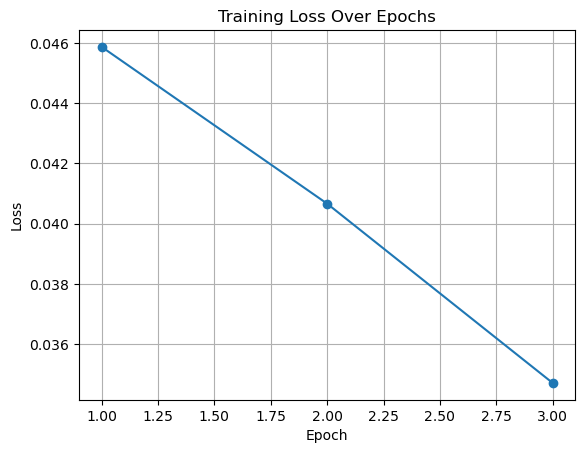

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Untuk mencatat loss selama pelatihan
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

# Training Loop
epochs = 3

model.fit(bpe_dataloader, epochs=epochs, callbacks=[history])

# Simpan model setelah kompilasi dan pelatihan
model_path = './saved_model/saved_notebook_06/model'
model.save(model_path)

# Visualisasi loss selama pelatihan
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), history.losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()


## GENERATIVE CONTENT

In [17]:
import numpy as np
import tensorflow as tf
import pickle

# Path untuk memuat model dan token vocab
model_path = './saved_model/saved_notebook_06/model'
token_vocab_path = './saved_model/saved_notebook_06/token_vocab.pkl'
inv_token_vocab_path = './saved_model/saved_notebook_06/inv_token_vocab.pkl'

# Muat model yang sudah dilatih
model = tf.keras.models.load_model(model_path, custom_objects={'PositionalEncoding': PositionalEncoding})

# Muat token vocab dan inv_token_vocab
with open(token_vocab_path, 'rb') as f:
    token_vocab = pickle.load(f)

with open(inv_token_vocab_path, 'rb') as f:
    inv_token_vocab = pickle.load(f)

def predict_text(model, input_text, token_vocab, inv_token_vocab, max_length=512, gen_length=50):
    # Tokenisasi input
    input_tokens = [token_vocab.get(c, token_vocab['<unk>']) for c in input_text]
    
    # Padding input tokens
    input_tokens_padded = np.pad(input_tokens, (0, max_length - len(input_tokens)), constant_values=token_vocab['<pad>'])
    input_tokens_padded = tf.expand_dims(input_tokens_padded, 0)  # Tambahkan dimensi batch

    generated_text = input_text
    
    for _ in range(gen_length):
        # Prediksi dengan model
        predictions = model(input_tokens_padded)
        predictions = predictions[:, len(input_tokens) - 1, :]  # Ambil prediksi dari token terakhir yang valid

        predicted_id = tf.argmax(predictions, axis=-1).numpy()[0]
        
        print(f"Predicted ID: {predicted_id}, Predicted Token: {inv_token_vocab[predicted_id]}")

        # Jika token <pad> atau <unk> dihasilkan, hentikan prediksi
        if predicted_id in [token_vocab['<pad>'], token_vocab['<unk>']]:
            break

        # Tambahkan token yang diprediksi ke input
        input_tokens.append(predicted_id)
        input_tokens_padded = np.pad(input_tokens, (0, max_length - len(input_tokens)), constant_values=token_vocab['<pad>'])
        input_tokens_padded = tf.expand_dims(input_tokens_padded, 0)  # Tambahkan dimensi batch

        # Tambahkan karakter yang diprediksi ke teks yang dihasilkan
        generated_text += inv_token_vocab[predicted_id]

        # Hentikan jika token akhir dihasilkan (misalnya token akhir kalimat)
        if inv_token_vocab[predicted_id] == '.':
            break

    return generated_text

# Pertanyaan sebagai input
input_question = "Apa yang dimaksud dengan jaringan saraf?"

# Hasilkan teks berdasarkan input
generated_text = predict_text(model, input_question, token_vocab, inv_token_vocab, max_length=512, gen_length=50)
print("Generated Text:", generated_text)

Predicted ID: 1, Predicted Token: <unk>
Generated Text: Apa yang dimaksud dengan jaringan saraf?


## Debugging dan Evaluasi

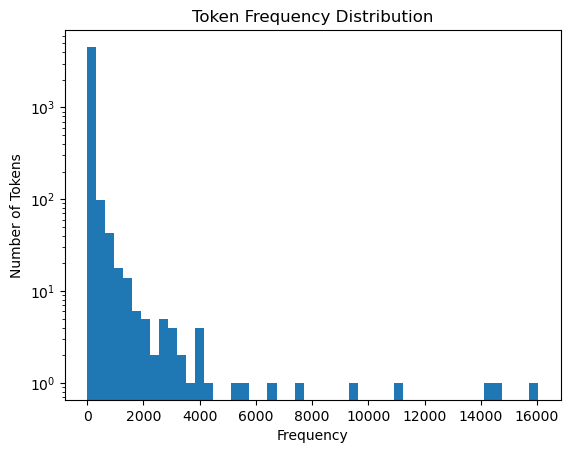

In [18]:
import matplotlib.pyplot as plt

# Distribusi frekuensi token
token_counts = [count for token, count in vocab.items() if count > 0]
plt.hist(token_counts, bins=50)
plt.yscale('log')
plt.title('Token Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Tokens')
plt.show()
